<a href="https://colab.research.google.com/github/lkarjun/fastai-huggingface-workouts/blob/main/notebook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [1]:
!pip install -qq transformers[sentencepiece] datasets
!pip install -qq fastai ohmeow-blurr
!pip install -qq wandb

     |████████████████████████████████| 3.5 MB 12.2 MB/s 
     |████████████████████████████████| 311 kB 45.4 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 38.3 MB/s 
     |████████████████████████████████| 243 kB 52.5 MB/s 
     |████████████████████████████████| 133 kB 52.1 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 271 kB 52.7 MB/s 
     |████████████████████████████████| 144 kB 48.6 MB/s 
     |████████████████████████████████| 895 kB 40.5 MB/s 
     |████████████████████████████████| 596 kB 44.6 MB/s 
     |████████████████████████████████| 6.8 MB 42.6 MB/s 
     |████████████████████████████████| 1.2 MB 48.4 MB/s 
     |████████████████████████████████| 91 kB 6.1 MB/s 
     |████████████████████████████████| 189 kB 45.2 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |██████████████████

## Fine-tuning with **Blurr**

In [2]:
import wandb

from fastai.text.all import *
from fastai.callback.wandb import *

from datasets import load_dataset, concatenate_datasets
from transformers import AutoModelForSequenceClassification

from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock
from blurr.modeling.core import Blearner, HF_BaseModelWrapper, HF_BaseModelCallback, hf_splitter

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
model_cls = AutoModelForSequenceClassification

checkpoint = 'bert-base-uncased'

In [24]:
bsz, val_bsz = 8, 16

wandb_init_kwargs = {
    'reinit': True,
    'project': 'notebook3-testing-fastai-x-hf',
    'entity': 'lkarjun',
    'group': 'glue-mrpc',
    'name': 'glue-mrpc-bert-base-uncased',
    'notes': 'Finetuning glue-mrpc with Blurr',
    'tags': ['bert', 'glue-mrpc', 'blurr']
}

### Using low / mid-level Api

In [8]:
raw_datasets = load_dataset(path = 'glue', name = 'mrpc')

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
print(f"{raw_datasets}\n")
print(f"{raw_datasets['train'][0]}\n")
print(f"{raw_datasets['train'].features}\n")

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0}

{'sentence1': Value(dtype='string', id=None), 'sentence2': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['not_equivalent', 'equivalent'], names_file=None, id=None), 'idx': Value(dtype='int32', id=None)}



## Data Preparation

In [10]:
n_train, n_valid = raw_datasets['train'].num_rows, raw_datasets['validation'].num_rows

In [11]:
train_idxs, valid_idxs = L(range(n_train), L(range(n_train, n_train + n_valid)))

raw_ds = concatenate_datasets([raw_datasets['train'], raw_datasets['validation']])

In [12]:
n_lbls = len(set([item['label'] for item in raw_ds]))
n_lbls

2

In [13]:
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(checkpoint, model_cls = model_cls, config_kwargs={'num_labels': n_lbls})

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
print(hf_model)

In [15]:
blocks = (
            HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model),
            CategoryBlock()
          )

dblock = DataBlock(
                   blocks = blocks,
                   get_x = itemgetter('sentence1', 'sentence2'),
                   get_y = itemgetter('label'),
                   splitter = IndexSplitter(valid_idxs)
                )

In [22]:
dls = dblock.dataloaders(raw_ds, bs = bsz, val_bs = val_bsz)

In [23]:
dls.show_batch(dataloaders = dls, max_n = 3)

,text,target
0,"with claritin's decline, schering - plough's best - selling products now are two drugs used together to treat hepatitis c, the antiviral pill ribavirin and an interferon medicine called peg - intron. with claritin's decline, schering - plough's best - selling products are now antiviral drug ribavirin and an interferon medicine called peg - intron - - two drugs used together to treat hepatitis c.",1
1,"he listed leapfrog enterprises'lf. n leappad books, hasbro inc.'s has. n beyblade starter set, and mga entertainment's bratz doll line as toys that were stealing market share. leapfrog enterprises'lf. n leappad books, hasbro inc.'s has. n beyblade starter set, and mga entertainment's bratz doll line all were stealing market share, he said.",1
2,"spot gold was fetching $ 365. 25 / 366. 25 an ounce at 0520 gmt, having galloped as high as $ 368. 90 - - a level not seen since february 10. spot gold was quoted at $ 367. 90 / 368. 60 an ounce at 1000 gmt, having marched up to $ 369. 50 - - a level not seen since february 10.",0


## Train

In [25]:
wandb.init(**wandb_init_kwargs)

wandb: Currently logged in as: lkarjun (use `wandb login --relogin` to force relogin)


In [27]:
# Using Low level Learner

model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls,
                model,
                opt_func=Adam,
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, F1Score()],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter
                )

learn.freeze()

In [29]:
# high level api
learn = Blearner(dls, hf_model, metrics=[accuracy, F1Score()])

In [30]:
learn.unfreeze()

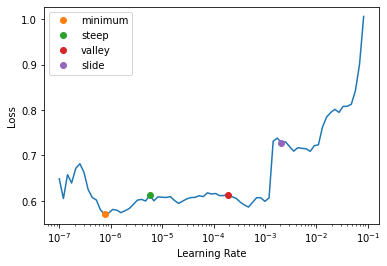

In [31]:
lr_res = learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [34]:
learn.fit_one_cycle(3, 
                    lr_max = 5e-5,
                    cbs = [WandbCallback(log_preds = False, log_model = False)])

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.473236,0.394996,0.806373,0.857143,02:03
1,0.305349,0.343044,0.867647,0.906250,02:03
2,0.075028,0.435637,0.870098,0.910321,02:05


5e-05


In [35]:
learn.show_results(learner = learn, max_n = 4)

,text,target,prediction
0,"he said the foodservice pie business doesn't fit the company's long - term growth strategy. "" the foodservice pie business does not fit our long - term growth strategy.",1,1
1,"only one of the five buildings in the baghdad compound of the united nations development program escaped being burned, the un said on its web site. only one of the five buildings in the compound in baghdad run by the un development program, escaped being burned, the un said on its web site.",1,1
2,"mccabe said he was considered a witness, not a suspect. "" he is not considered a suspect, "" mccabe said.",0,1
3,"based on a separate survey of households, the unemployment rate fell in august to 6. 1 percent from 6. 2 percent. labor department analysts discounted a slight improvement in the national unemployment rate, which fell in august to 6. 1 percent from 6. 2 percent.",0,0


## Evaluate

In [36]:
val_res = learn.validate()

In [37]:
val_res_d = {'loss': val_res[0]}

for idx, m, in enumerate(learn.metrics):
  val_res_d[m.name] = val_res[idx+1]

val_res_d

{'accuracy': 0.8700980544090271,
 'f1_score': 0.9103214890016922,
 'loss': 0.43563729524612427}

In [38]:
preds, targs, losses = learn.get_preds(with_loss = True)

In [39]:
print(preds.shape, targs.shape, losses.shape)

torch.Size([408, 2]) torch.Size([408]) torch.Size([408])


In [40]:
print(losses.mean(), accuracy(preds, targs))

TensorBase(0.4356) TensorBase(0.8701)


In [41]:
wandb.finish()

accuracy,▁██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_3,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_score,▁▇█
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_2,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_3,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁


## Inference

In [42]:
learn.export("mrpc_learner.pkl")

In [43]:
my_learn = load_learner('mrpc_learner.pkl')

In [45]:
my_learn.blurr_predict(
    {'sentence1': 'This is good work.',
     'sentence2': 'Actually when you started this.'}
     )

[(('0',), (#1) [tensor(0)], (#1) [tensor([0.9924, 0.0076])])]

In [48]:
my_learn.model.hf_model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [58]:
my_learn.blurr_predict(
    [{'sentence1': 'This is good work.',
     'sentence2': 'This is completely different.'},
    {'sentence1': "You are a better person.",
     'sentence2': "You are better than last year."}]
     )

[(('0',), (#1) [tensor(0)], (#1) [tensor([0.9935, 0.0065])]),
 (('1',), (#1) [tensor(1)], (#1) [tensor([0.1710, 0.8290])])]

In [59]:
# Batch Inference

In [60]:
test_dl = my_learn.dls.test_dl(raw_datasets['test'].select(range(100)))

In [65]:
preds = my_learn.get_preds(dl = test_dl)

In [82]:
preds[0][:10]

tensor([[0.0056, 0.9944],
        [0.0099, 0.9901],
        [0.0014, 0.9986],
        [0.0057, 0.9943],
        [0.9932, 0.0068],
        [0.0014, 0.9986],
        [0.9937, 0.0063],
        [0.0700, 0.9300],
        [0.0031, 0.9969],
        [0.9909, 0.0091]])

## Using High level api

In [83]:
from blurr.modeling.core import BlearnerForSequenceClassification

In [84]:
raw_datasets = load_dataset('glue', 'mrpc')

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [85]:
train_df = raw_datasets['train'].to_pandas()
train_df['is_valid'] = False

valid_df = raw_datasets['validation'].to_pandas()
valid_df['is_valid'] = True

In [86]:
df = pd.concat([train_df, valid_df])

In [87]:
wandb.init(**wandb_init_kwargs)

In [90]:
learn = BlearnerForSequenceClassification.from_dataframe(df, 
                                                         checkpoint, 
                                                         text_attr = ['sentence1', 'sentence2'], 
                                                         label_attr = 'label',
                                                         dl_kwargs = {'bs': 20, 'val_bs': 30}
                                                         )

In [91]:
learn.unfreeze()

In [92]:
learn.fit_one_cycle(3, 
                    lr_max = 5e-5, 
                    cbs = [WandbCallback(log_preds = False, log_model = False)])

Could not gather input dimensions


epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.512715,0.442161,0.855346,0.774510,01:24
1,0.308121,0.331273,0.901361,0.857843,01:25
2,0.102530,0.395309,0.899306,0.857843,01:25


In [93]:
learn.show_results(learner = learn, max_n = 3)

,text,target,prediction
0,"he said the foodservice pie business doesn't fit the company's long - term growth strategy. "" the foodservice pie business does not fit our long - term growth strategy.",1,1
1,"however, a recent slide in prices and opec's expectations of a surge in oil inventories have compounded its fears about a further softening of the market. a 14 percent slide in crude prices this month and expectations of a build up in oil inventories compounded opec's fears of a further softening of the market.",1,1
2,the first products are likely to be dongles costing between us $ 100 and us $ 150 that will establish connections between consumer electronics devices and pcs. the first products will likely be dongles costing $ 100 to $ 150 that will establish connections between consumer electronics devices and pcs.,1,1


In [94]:
# inference works this same as above

In [95]:
learn.export('mrpc_learner2.pkl')

In [96]:
inf_learn2 = load_learner('mrpc_learner2.pkl')

In [97]:
print(df[['sentence1', 'sentence2']].iloc[0])

sentence1            Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
sentence2    Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
Name: 0, dtype: object


In [99]:
inf_learn2.blurr_predict([L('I Love cats', 'I kind of like cats')])

[(('1',), (#1) [tensor(1)], (#1) [tensor([0.0197, 0.9803])])]

In [102]:
test_df = (raw_datasets['test'].select(range(100))).to_pandas()

In [103]:
test_df = inf_learn2.dls.test_dl(test_df)

In [105]:
preds = inf_learn2.get_preds(dl=test_df)

In [106]:
preds[0][:10]

tensor([[0.0055, 0.9945],
        [0.1784, 0.8216],
        [0.0040, 0.9960],
        [0.0152, 0.9848],
        [0.9847, 0.0153],
        [0.0041, 0.9959],
        [0.9707, 0.0293],
        [0.9791, 0.0209],
        [0.0066, 0.9934],
        [0.9855, 0.0145]])

In [107]:
wandb.finish()

accuracy,▁██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_3,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_score,▁██
lr_0,▁▁▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_2,▁▁▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_3,▁▁▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
